Ilona Smith - 2471308\
Luca von Mayer - 2427051\
Tumi Jourdan - 2180153\
Tao Yuan - 2332155

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import fiona
import shapely
import geopandas
import seaborn as sns
#import sklearn.cluster.DBSCAN
from datetime import datetime

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [2]:
df = pd.read_csv('nyc_taxis.csv', low_memory=False)

Entris removed 47548


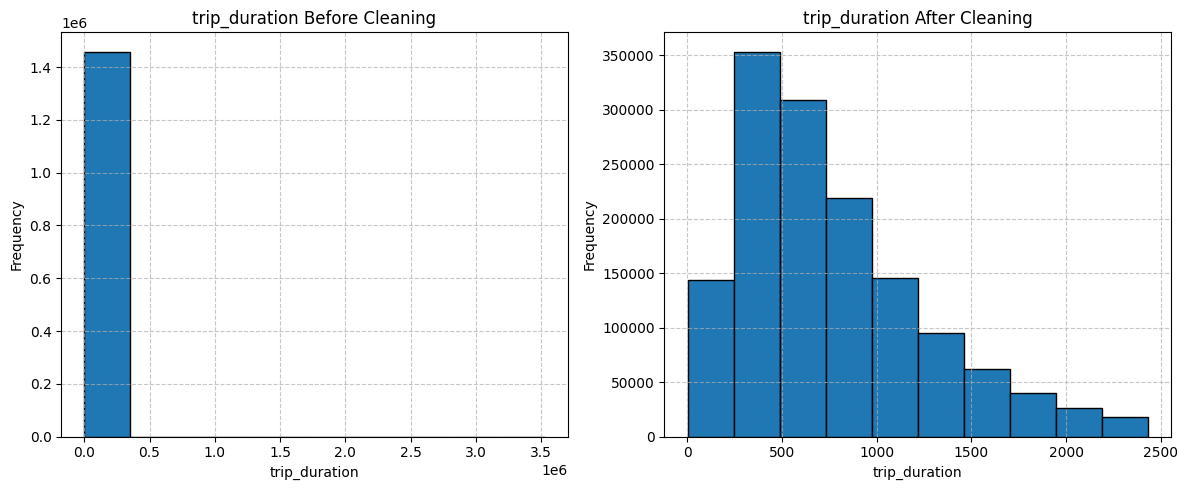

In [3]:
#Q1 
def clean_IQR(df_in, columns= [' ', ' ', ' ', ' ', ' ', ' '],iqr_scale = 1.5,plot = False):
    temp_df = df_in.copy()
    
    # Filter the DataFrame for the current currency
    
    for column in columns:
        Q1 = float(temp_df[column].quantile(0.25))
        Q3 = float(temp_df[column].quantile(0.75))
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_scale * IQR
        upper_bound = Q3 + iqr_scale * IQR

        # Filter the data based on the calculated bounds
        temp_df = temp_df[(temp_df[column] >= lower_bound) & (temp_df[column] <= upper_bound)]
        if (plot):
            print("Entries removed",df_in.shape[0]-temp_df.shape[0])
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.hist(df_in[column], bins=10, edgecolor='black')
            plt.title(f'{column} Before Cleaning')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(True, linestyle='--', alpha=0.7)     
            
            plt.subplot(1, 2, 2)
            plt.hist(temp_df[column], bins=10, edgecolor='black')
            plt.title(f'{column} After Cleaning')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(True, linestyle='--', alpha=0.7)   
            
            plt.tight_layout()
            plt.show()            

    # Update temp_df with the filtered country_df
    
    return temp_df      

df['trip_duration'] = df['trip_duration'].astype(int)
df = clean_IQR(df,columns=['trip_duration'],iqr_scale=2,plot=True)

In [4]:
#Question 2

# 1. Distance of trip
df['trip_distance_km'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'],
                                      df['dropoff_longitude'], df['dropoff_latitude'])

# 2. Day of the week
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# 3. Average speed of trip
# Convert trip duration from seconds to hours
df['trip_duration_hours'] = df['trip_duration'] / 3600
df['average_speed_kmh'] = df['trip_distance_km'] / df['trip_duration_hours']

# Display the first few rows to check the new features
print(df[['trip_distance_km', 'day_of_week', 'average_speed_kmh']].head())

   trip_distance_km day_of_week  average_speed_kmh
0          1.497580      Monday          11.848984
1          1.804374      Sunday           9.797504
2          6.381090     Tuesday          10.815406
3          1.484566   Wednesday          12.457894
4          1.187842    Saturday           9.830418


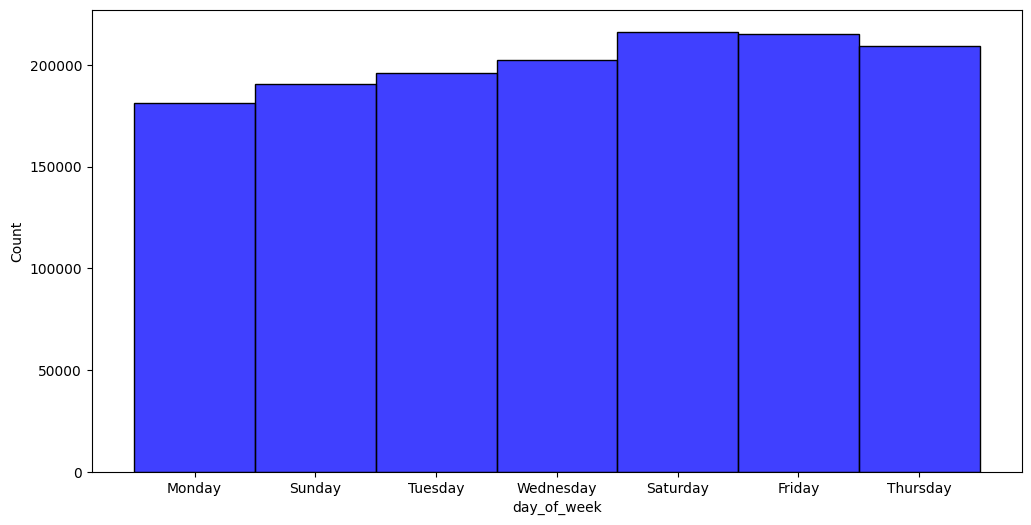

In [10]:
#Question 3
#1
dfCopy = df.copy()
dfCopy['day_of_week'] = df['day_of_week']

# Increase the width of the graph
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

# Plotting the histogram
sns.histplot(dfCopy['day_of_week'], bins=7, discrete=True, kde=False, color='blue')

# Display the plot
plt.show()



/tmp/ipykernel_4047/1872725515.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  times = dfCopy.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)


<Figure size 2000x2000 with 0 Axes>

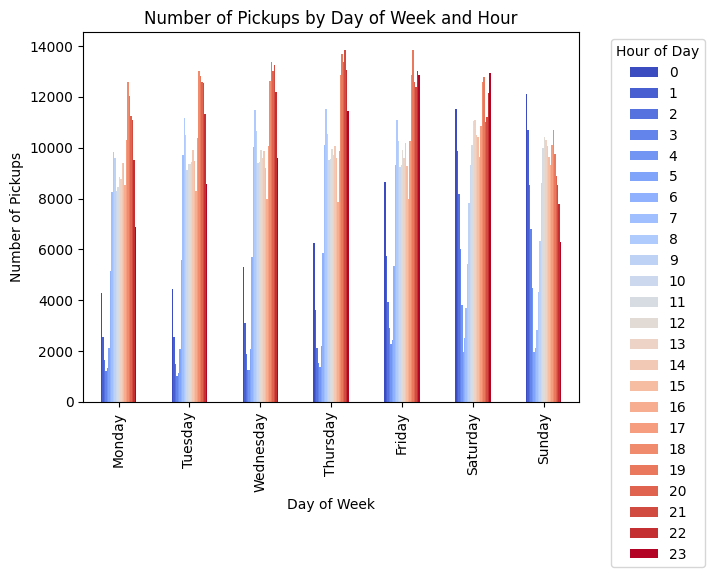

In [6]:
#2
dfCopy = df.copy()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dfCopy['day_of_week'] = pd.Categorical(dfCopy['day_of_week'], categories=days_order, ordered=True)

# Extract hour from pickup_datetime
dfCopy['hour'] = dfCopy['pickup_datetime'].dt.hour

# Group by day_of_week and hour, and count occurrences
times = dfCopy.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Plotting the data
plt.figure(figsize=(20, 20))
ax = times.plot(kind='bar', stacked=False, colormap='coolwarm')

plt.title('Number of Pickups by Day of Week and Hour')
plt.ylabel('Number of Pickups')
plt.xlabel('Day of Week')

# Adjust the legend position
plt.legend(title='Hour of Day', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

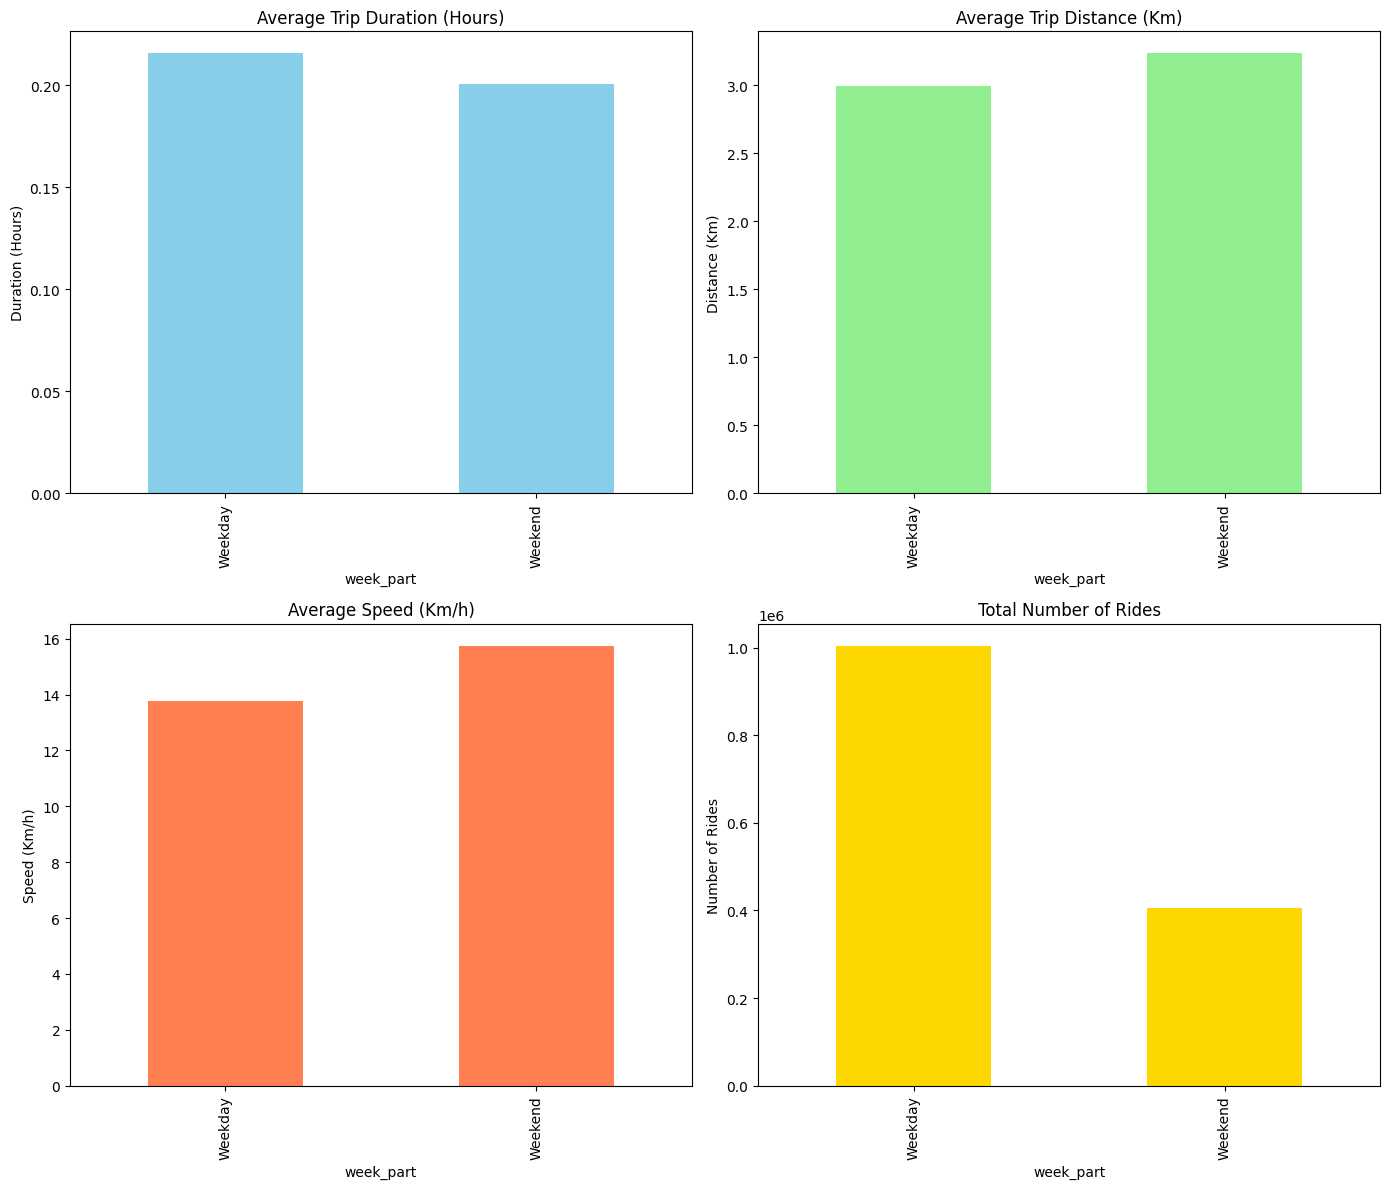

In [7]:
#3 average duration, distance, speed for weekdays/ends and tyou otal rides 
df.head(3)
dfCopy = df.copy()
df['week_part'] = df['day_of_week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')
summary = df.groupby('week_part').agg({
    'trip_duration_hours': 'mean',
    'trip_distance_km': 'mean',
    'average_speed_kmh': 'mean',
    'id': 'count'
}).rename(columns={'id': 'total_rides'})

fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Plot average duration
summary['trip_duration_hours'].plot(kind='bar', ax=ax[0, 0], color='skyblue')
ax[0, 0].set_title('Average Trip Duration (Hours)')
ax[0, 0].set_ylabel('Duration (Hours)')

# Plot average distance
summary['trip_distance_km'].plot(kind='bar', ax=ax[0, 1], color='lightgreen')
ax[0, 1].set_title('Average Trip Distance (Km)')
ax[0, 1].set_ylabel('Distance (Km)')

# Plot average speed
summary['average_speed_kmh'].plot(kind='bar', ax=ax[1, 0], color='coral')
ax[1, 0].set_title('Average Speed (Km/h)')
ax[1, 0].set_ylabel('Speed (Km/h)')

# Plot total rides
summary['total_rides'].plot(kind='bar', ax=ax[1, 1], color='gold')
ax[1, 1].set_title('Total Number of Rides')
ax[1, 1].set_ylabel('Number of Rides')

plt.tight_layout()
plt.show()

In [8]:
#4 


/tmp/ipykernel_4047/2907316830.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_speed_per_day = dfCopy.groupby('day_of_week')['average_speed_kmh'].mean()


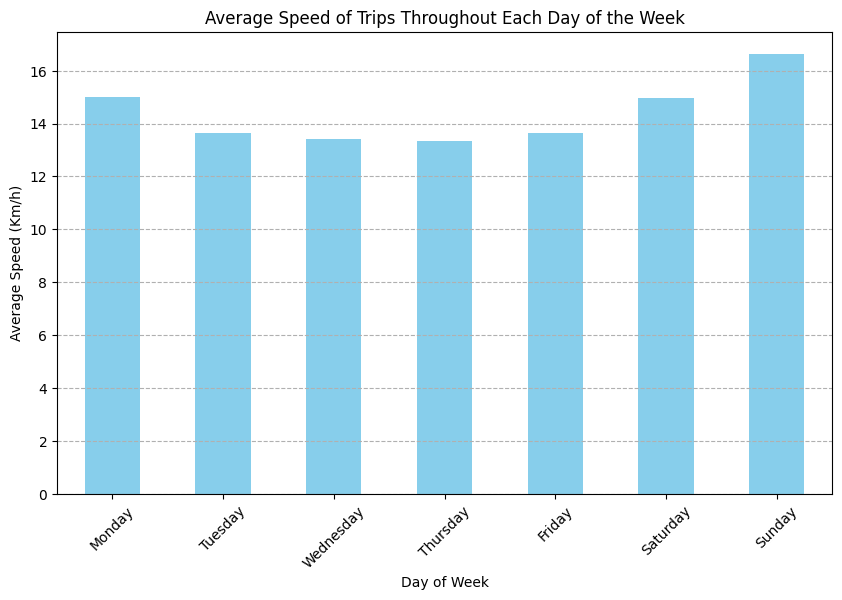

In [9]:
#5 
dfCopy = df.copy()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dfCopy['day_of_week'] = pd.Categorical(dfCopy['day_of_week'], categories=days_order, ordered=True)
avg_speed_per_day = dfCopy.groupby('day_of_week')['average_speed_kmh'].mean()

plt.figure(figsize=(10, 6))
avg_speed_per_day.plot(kind='bar', color='skyblue')

plt.title('Average Speed of Trips Throughout Each Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Speed (Km/h)')
plt.xticks(rotation=45)  # Rotate x labels if necessary
plt.grid(axis='y', linestyle='--')

plt.show()